### This notebook forecast average price of selling avocados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats

In [61]:
df_google = pd.read_csv('GoogleData.csv')

In [62]:
df_google.rename(columns={'Unnamed: 0': 'Date'},inplace=True)

In [2]:
df_prices = pd.read_csv('prices.csv')

In [3]:
df_prices.head()

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,2015-01-04,NaN,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston


#### First I am going to inspect and address missing values

In [4]:
df_prices.isnull().sum()

Date              0
AveragePrice    902
TotalVolume     949
4046            900
4225            906
4770            916
TotalBags       890
SmallBags       934
LargeBags       947
XLargeBags      868
type              0
year              0
region            0
dtype: int64

### Let's check original distribution of prices 

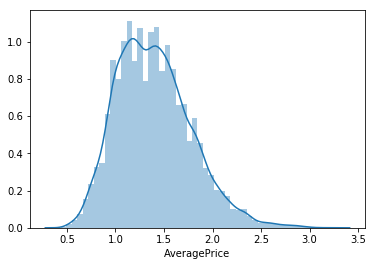

In [7]:
sns.distplot(df_prices['AveragePrice'].dropna())

### If we use pandas ffill method to imput missing values, this does not affect original distribution

In [5]:
df_prices['AveragePrice'] = df_prices['AveragePrice'].fillna(method='ffill')

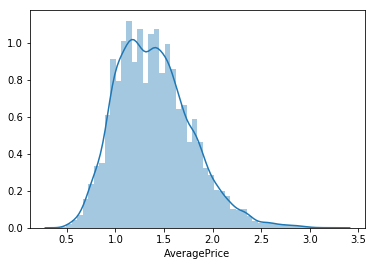

In [6]:
sns.distplot(df_prices['AveragePrice'])

### Since intuitevely AveragePrice affect TotalBags and TotalVolume which I will analyse later in the notebook, I will also imput missing values for them.
### TotalBags is sum of all bags so accordingly calculate missing values.

In [7]:
def fill_mising_bags(df):
    
    fill_TotalBags = df['SmallBags']+df['LargeBags']+df['XLargeBags']
    
    df['TotalBags'] = fill(df,fill_TotalBags,'TotalBags')
    
    fill_SmallBags = df['TotalBags']-(df['LargeBags']+df['XLargeBags'])
    
    df['SmallBags'] = fill(df,fill_SmallBags,'SmallBags')
    
    fill_LargeBags = df['TotalBags']-(df['SmallBags']+df['XLargeBags'])
    
    df['LargeBags'] = fill(df,fill_LargeBags,'LargeBags')
    
    fill_XLargeBags = df['TotalBags']-(df['SmallBags']+df['LargeBags'])
    
    df['XLargeBags'] = fill(df,fill_XLargeBags,'XLargeBags')
    
    return df

In [8]:
def fill(df,to_fill,col):
    
    df[col] = df[col].fillna(to_fill)
    
    return df[col]

In [10]:
df_prices = fill_mising_bags(df_prices)

In [11]:
df_prices.isnull().sum()

Date              0
AveragePrice      0
TotalVolume     949
4046            900
4225            906
4770            916
TotalBags       119
SmallBags       124
LargeBags       148
XLargeBags      123
type              0
year              0
region            0
dtype: int64

### We noticed more around 800 values imputed in this way.
### Now let's do the same for TotalVolume which is sum of 4046,4225,4770 and TotalBags

In [12]:
def fill_total_units(df):
    
    fill_TotalVolume = df['4046']+df['4225']+df['4770']+df['TotalBags']
    
    df['TotalVolume'] = fill(df,fill_TotalVolume,'TotalVolume')
    
    fill_4046 = df['TotalVolume']-(df['4225']+df['4770']+df['TotalBags'])
    
    df['4046'] = fill(df,fill_4046,'4046')
    
    fill_4225 = df['TotalVolume']-(df['4046']+df['4770']+df['TotalBags'])
    
    df['4225'] = fill(df,fill_4225,'4225')
    
    fill_4770 = df['TotalVolume']-(df['4225']+df['4046']+df['TotalBags'])
    
    df['4770'] = fill(df,fill_4770,'4770')
    
    return df

In [13]:
df_prices = fill_total_units(df_prices)

In [14]:
df_prices.isnull().sum()

Date              0
AveragePrice      0
TotalVolume     136
4046            136
4225            132
4770            118
TotalBags       119
SmallBags       124
LargeBags       148
XLargeBags      123
type              0
year              0
region            0
dtype: int64

### Let missing values I will try to get rid of during the grouping.
### Let's see type of avocado and region can we use it

In [32]:
def label_encoder(df,col):
    
    le = preprocessing.LabelEncoder()
    le.fit(df[col])
    encoded = le.transform(df[col]) 
    df[col+'_encoded'] = pd.Series(encoded)
    
    return df

In [33]:
df_prices = label_encoder(df_prices,'type')

In [34]:
df_prices = label_encoder(df_prices,'region')

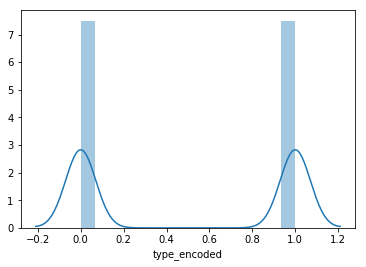

In [35]:
sns.distplot(df_prices['type_encoded'])

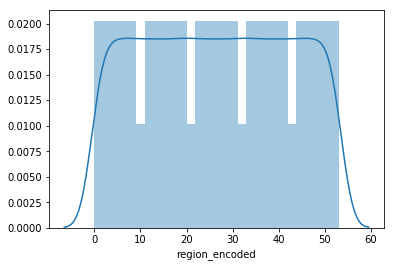

In [36]:
sns.distplot(df_prices['region_encoded'])

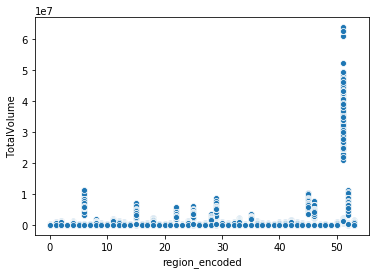

In [113]:
sns.scatterplot(df_prices['region_encoded'],df_prices['TotalVolume'])

Text(0.5, 1.0, 'Total volume of avocado sold')

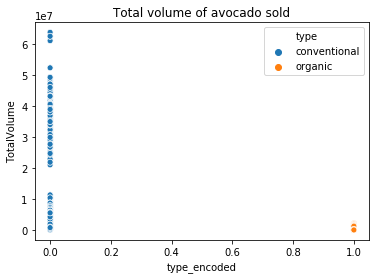

In [146]:
ax = sns.scatterplot(df_prices['type_encoded'],df_prices['TotalVolume'],hue=df_prices['type'])
ax.set_title('Total volume of avocado sold')

Text(0.5, 1.0, 'Price difference of avocado sold')

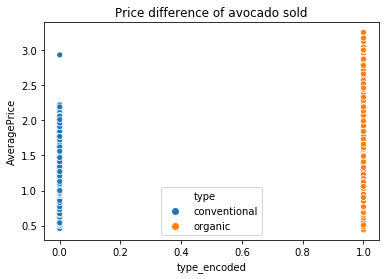

In [147]:
ax = sns.scatterplot(df_prices['type_encoded'],df_prices['AveragePrice'],hue=df_prices['type'])
ax.set_title('Price difference of avocado sold')

In [150]:
df_prices[df_prices['type']=='conventional']['AveragePrice'].mean()

1.1595700206644464

In [151]:
df_prices[df_prices['type']=='organic']['AveragePrice'].mean()

1.6328809921297336

#### So both distributions are uniformly distributed. However, we see drastic difference in seeling between organic (1) and conventional avocado (0) even though price difference on average is around 50 cents. 

In [17]:
def plot_amount(df,col):
    
    df = df.sort_values('Date',ascending=True)
    
    fig,ax=plt.subplots(figsize=(14,8))
    
    ax=sns.scatterplot('Date',col,data=df)
    ax.set_xlim(df['Date'].min(),df['Date'].max())

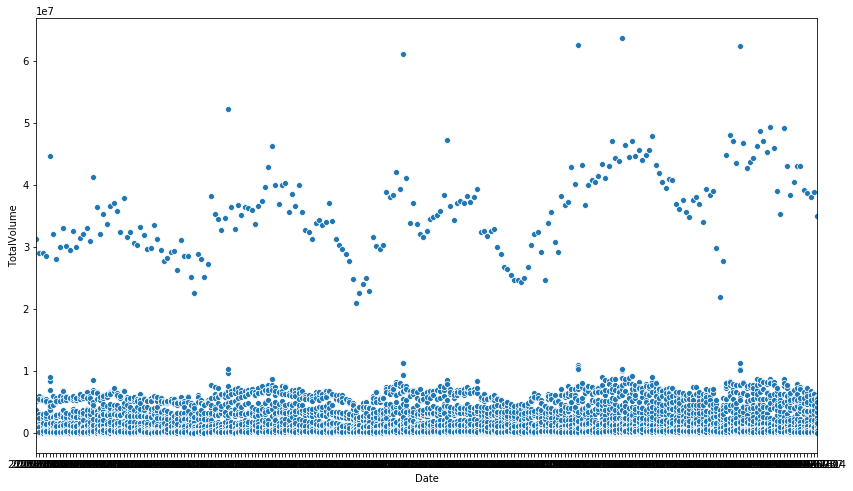

In [18]:
plot_amount(df_prices,'TotalVolume')

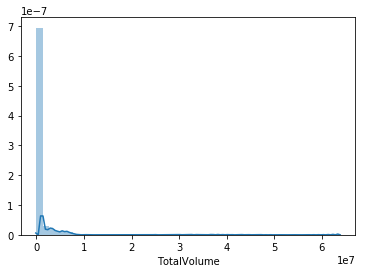

In [20]:
sns.distplot(df_prices['TotalVolume'].dropna())

### We can notice some noice in histogram and scatter plot so I will apply outlier removal with zscore=3

In [21]:
def remove_outliers(df,cols):
    
    df_new = pd.DataFrame()
    
    for col in cols:
        
        z = np.abs(stats.zscore(df[col]))
        
        temp = df.iloc[np.where(z < 3)[0]]
        
        df_new = pd.concat([df_new,temp],axis=0)
        
        return df_new

In [22]:
df_prices_filt = remove_outliers(df_prices,['AveragePrice','SmallBags','LargeBags','XLargeBags','TotalBags','4046','4225','4770','TotalVolume'])

In [23]:
df_prices_filt.head()

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,2015-01-04,1.00,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston


In [24]:
df_prices_filt['Date'] = pd.to_datetime(df_prices_filt['Date'])

#### Let's not group variables according to purshasing Date and create new features based on statistics 

In [26]:
df_groupby = df_prices_filt.groupby('Date')['AveragePrice','4046','4225','4770','SmallBags','LargeBags','XLargeBags','TotalBags','TotalVolume'].agg(['mean','min','max']).reset_index()

In [27]:
def levels(df):
    
    level0 = df.columns.get_level_values(0)

    level1 = df.columns.get_level_values(1)

    df.columns = level0 + '_' + level1
    
    return df

In [28]:
df_groupby = levels(df_groupby)

In [29]:
df_groupby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 28 columns):
Date_                233 non-null datetime64[ns]
AveragePrice_mean    233 non-null float64
AveragePrice_min     233 non-null float64
AveragePrice_max     233 non-null float64
4046_mean            233 non-null float64
4046_min             233 non-null float64
4046_max             233 non-null float64
4225_mean            233 non-null float64
4225_min             233 non-null float64
4225_max             233 non-null float64
4770_mean            233 non-null float64
4770_min             233 non-null float64
4770_max             233 non-null float64
SmallBags_mean       233 non-null float64
SmallBags_min        233 non-null float64
SmallBags_max        233 non-null float64
LargeBags_mean       233 non-null float64
LargeBags_min        233 non-null float64
LargeBags_max        233 non-null float64
XLargeBags_mean      233 non-null float64
XLargeBags_min       233 non-null float64
XLarge

In [23]:
df_groupby.head()

,Date_,AveragePrice_mean,4046_mean,4225_mean,4770_mean,SmallBags_mean,LargeBags_mean,XLargeBags_mean,TotalBags_mean,TotalVolume_mean
0,2015-01-04,1.317130,306465.358704,341213.318796,21100.172593,93624.194660,24117.389216,490.840680,119075.949904,7.840216e+05
1,2015-01-11,1.366019,289035.714393,303781.757778,21751.550463,99658.819697,19351.208400,435.928687,119305.813700,7.056054e+05
2,2015-01-18,1.395093,297221.520000,298666.926698,20637.855607,101182.939515,13207.779223,201.363208,122958.558350,7.394612e+05
3,2015-01-25,1.399630,301877.024673,267862.244167,19424.101495,104106.798431,21826.248725,220.965644,117674.171262,6.914529e+05
4,2015-02-01,1.251389,465675.823704,469409.541481,34459.760467,65358.247778,28182.174135,1085.095545,137658.960769,1.106048e+06


### Let's now calculate portion of each bag or item code to the totalvolume and totalbags

In [37]:
def create_percentage(df,ll,divide_col):
    
    #ll = ['SmallBags_mean','LargeBags_mean','XLargeBags_mean']
    
    for l in ll:
        
        df[l+'_ratio'] = round(df[l]/df[divide_col],2)
        
    return df

In [38]:
ll = ['SmallBags_mean','LargeBags_mean','XLargeBags_mean']
df_groupby = create_percentage(df_groupby,ll,'TotalBags_mean')

In [39]:
ll1 = ['4046_mean','4225_mean','4770_mean','TotalBags_mean']
df_groupby = create_percentage(df_groupby,ll,'TotalVolume_mean')

In [40]:
df_groupby.head()

,Date_,AveragePrice_mean,AveragePrice_min,AveragePrice_max,4046_mean,4046_min,4046_max,4225_mean,4225_min,4225_max,...,XLargeBags_max,TotalBags_mean,TotalBags_min,TotalBags_max,TotalVolume_mean,TotalVolume_min,TotalVolume_max,SmallBags_mean_ratio,LargeBags_mean_ratio,XLargeBags_mean_ratio
0,2015-01-04,1.317130,0.65,2.32,306465.358704,0.0,12357161.34,341213.318796,23.64,13624083.05,...,18672.81,116283.548598,216.17,4498940.02,7.840216e+05,379.82,31324277.73,0.12,0.03,0.0
1,2015-01-11,1.366019,0.61,2.29,289035.714393,0.0,11544810.53,303781.757778,15.81,12134773.38,...,15789.15,115914.839811,33.33,4517384.18,7.056054e+05,761.86,29063542.75,0.14,0.03,0.0
2,2015-01-18,1.395093,0.67,2.35,297221.520000,0.0,11858139.34,298666.926698,2.64,11701947.80,...,7935.35,117738.747593,112.58,4652069.81,7.394612e+05,627.80,29043458.85,0.13,0.03,0.0
3,2015-01-25,1.399630,0.61,2.29,301877.024673,0.0,12167445.03,267862.244167,10.61,10734652.82,...,8631.31,121793.027500,80.00,4800192.94,7.080211e+05,711.52,28470310.84,0.14,0.03,0.0
4,2015-02-01,1.251389,0.56,1.98,465675.823704,0.0,18933038.04,469409.541481,16.62,18956479.74,...,46899.12,136819.689815,96.67,5384427.62,1.106048e+06,769.05,44655461.51,0.10,0.03,0.0


#### Nice so far we have 29 features excluding Date and target variable

#### Now we can do some plots and see if we can find somethig interesting there

In [42]:
def plot_dates(df,col):
    
    df = df.sort_values('Date',ascending=True)
    
    fig,ax=plt.subplots(figsize=(10,8))
    
    ax=sns.scatterplot('Date',col,data=df)
    ax.set_xlim(df['Date'].min(),df['Date'].max())

/home/momir/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


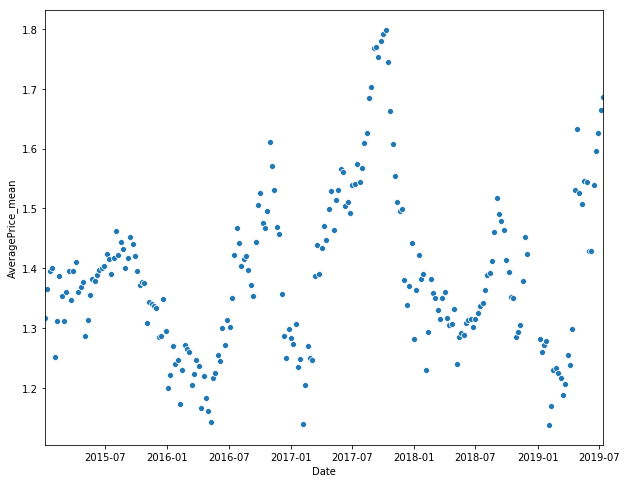

In [44]:
df_groupby = df_groupby.rename(columns={'Date_':'Date'})
plot_dates(df_groupby,'AveragePrice_mean')

#### We see sesonality component expressed, in late summer and early autumn times (August and September, October) prices are highest while in winter time and early spring lowest (February, March, April)

#### Now let's see how purchasing behavior relates to prices

In [152]:
def plot_dependencies(df,col,col1):
    
    df = df.sort_values('Date',ascending=True)
    
    fig,ax=plt.subplots(figsize=(10,8))
    
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    
    ax=sns.scatterplot('Date',col,hue=col1,size=col1,palette=cmap,data=df)
    
    ax.set_title('Price changes over time for %s'%col1)
    
    ax.set_xlim(df['Date'].min(),df['Date'].max())

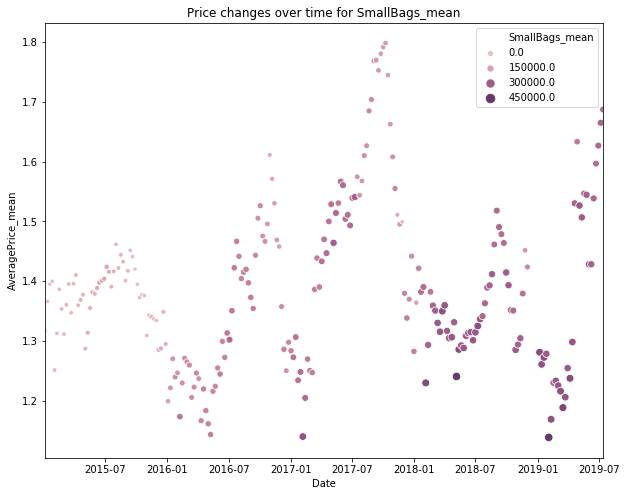

In [153]:
plot_dependencies(df_groupby,'AveragePrice_mean','SmallBags_mean')

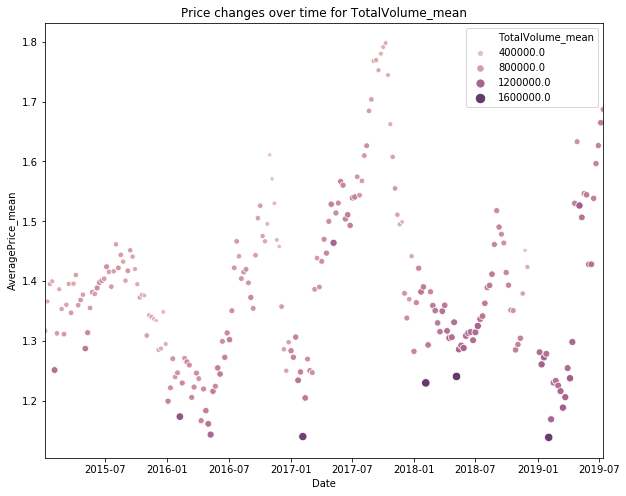

In [154]:
plot_dependencies(df_groupby,'AveragePrice_mean','TotalVolume_mean')

### It seems that avocado prices are too high for purhasing so people avoid buying it during the high prices period.

In [49]:
df_groupby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 31 columns):
Date                     233 non-null datetime64[ns]
AveragePrice_mean        233 non-null float64
AveragePrice_min         233 non-null float64
AveragePrice_max         233 non-null float64
4046_mean                233 non-null float64
4046_min                 233 non-null float64
4046_max                 233 non-null float64
4225_mean                233 non-null float64
4225_min                 233 non-null float64
4225_max                 233 non-null float64
4770_mean                233 non-null float64
4770_min                 233 non-null float64
4770_max                 233 non-null float64
SmallBags_mean           233 non-null float64
SmallBags_min            233 non-null float64
SmallBags_max            233 non-null float64
LargeBags_mean           233 non-null float64
LargeBags_min            233 non-null float64
LargeBags_max            233 non-null float64
XLargeBags_mea

### Now let's create additional feature based on trimesters we identify for AveragePrice

In [53]:
def create_datetime_features(df, label=None):
    
    df1 = df.copy()
    """
    Creates time series features from datetime index
    """
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['weekofyear'] = df['Date'].dt.weekofyear
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    
   
    return df

In [54]:
df_groupby = create_datetime_features(df_groupby)

In [51]:
def create_custom_trimester(df):
    
    '''
    Keys in month_dict correspond to growth or decay trends in average price plot
    August,September,October is one group
    Frebruary,March,April another group and so on
    '''
    
    month_dict = {8:1,9:1,10:1,2:2,3:2,4:2,11:3,12:3,1:3,5:4,6:4,7:4}
    
    df['selling_trimester'] = df['month'].map(month_dict)
    
    return df

In [55]:
df_groupby = create_custom_trimester(df_groupby)

In [ ]:
#### Calculate some statistics based on trimester averageprice traends

In [56]:
def calc_trimester_stats(df):
    
    df1 = df.groupby(['selling_trimester','year'])['AveragePrice_mean'].agg(['mean']).reset_index()
    
    return df1

In [57]:
df_trimester_grouped = calc_trimester_stats(df_groupby)

In [58]:
df_all_grouped = pd.merge(df_groupby,df_trimester_grouped,on=['selling_trimester','year'],how='left')

In [59]:
df_all_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 36 columns):
Date                     233 non-null datetime64[ns]
AveragePrice_mean        233 non-null float64
AveragePrice_min         233 non-null float64
AveragePrice_max         233 non-null float64
4046_mean                233 non-null float64
4046_min                 233 non-null float64
4046_max                 233 non-null float64
4225_mean                233 non-null float64
4225_min                 233 non-null float64
4225_max                 233 non-null float64
4770_mean                233 non-null float64
4770_min                 233 non-null float64
4770_max                 233 non-null float64
SmallBags_mean           233 non-null float64
SmallBags_min            233 non-null float64
SmallBags_max            233 non-null float64
LargeBags_mean           233 non-null float64
LargeBags_min            233 non-null float64
LargeBags_max            233 non-null float64
XLargeBags_mea

In [ ]:
### Let's join this datset with Google's data

In [63]:
df_google['Date'] = pd.to_datetime(df_google['Date'])

In [64]:
df_all = pd.merge(df_all_grouped,df_google,on='Date',how='inner')

#### Examine some correlations

In [65]:
df_all.corr()

,AveragePrice_mean,AveragePrice_min,AveragePrice_max,4046_mean,4046_min,4046_max,4225_mean,4225_min,4225_max,4770_mean,...,month,year,selling_trimester,mean,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
AveragePrice_mean,1.000000,0.819055,0.587385,-0.417176,0.159372,-0.444433,-0.582192,0.145875,-0.574954,-0.565786,...,0.420559,0.077251,-0.152244,0.832410,-0.293567,-0.135988,-0.395257,0.083969,-0.245605,-0.018450
AveragePrice_min,0.819055,1.000000,0.367594,-0.448962,0.099516,-0.456751,-0.437184,0.086998,-0.429384,-0.383630,...,0.393395,0.246545,-0.197981,0.732972,-0.142551,-0.069215,-0.324454,0.207867,-0.226819,0.094665
AveragePrice_max,0.587385,0.367594,1.000000,-0.387712,-0.014709,-0.395932,-0.360316,-0.016183,-0.356810,-0.255469,...,0.308476,-0.220195,0.001568,0.510085,-0.317153,-0.032389,-0.244746,-0.214256,-0.241697,-0.247217
4046_mean,-0.417176,-0.448962,-0.387712,1.000000,0.039932,0.982373,0.656827,0.112157,0.640713,0.264531,...,-0.533027,0.157814,0.227386,-0.247253,0.541450,0.228904,0.613114,0.261853,0.506946,0.230396
4046_min,0.159372,0.099516,-0.014709,0.039932,1.000000,0.008035,-0.003242,-0.015985,-0.007395,-0.048247,...,0.001739,-0.094804,-0.079997,0.128442,-0.084277,-0.084603,-0.072178,-0.074156,0.023494,-0.090256
4046_max,-0.444433,-0.456751,-0.395932,0.982373,0.008035,1.000000,0.673679,0.094653,0.681505,0.282597,...,-0.519349,0.175369,0.251460,-0.280675,0.548485,0.215899,0.612506,0.266523,0.500106,0.242611
4225_mean,-0.582192,-0.437184,-0.360316,0.656827,-0.003242,0.673679,1.000000,-0.021939,0.979011,0.659596,...,-0.452301,-0.083853,0.175071,-0.362485,0.415629,0.243519,0.597805,0.006367,0.374268,0.071919
4225_min,0.145875,0.086998,-0.016183,0.112157,-0.015985,0.094653,-0.021939,1.000000,-0.033818,-0.235636,...,0.036037,0.108551,-0.018737,0.192430,0.062110,0.060861,0.028127,0.174621,0.112958,0.078636
4225_max,-0.574954,-0.429384,-0.356810,0.640713,-0.007395,0.681505,0.979011,-0.033818,1.000000,0.642958,...,-0.431142,-0.085395,0.199953,-0.367681,0.391115,0.206852,0.578935,-0.001485,0.344286,0.066389
4770_mean,-0.565786,-0.383630,-0.255469,0.264531,-0.048247,0.282597,0.659596,-0.235636,0.642958,1.000000,...,-0.382890,-0.225349,0.163583,-0.491225,0.256318,0.148769,0.456682,-0.205013,0.201887,-0.055457


#### To make sure that there is no multicollinearity I will filter high correlated features 

In [66]:
def drop_high_correlations(df):
    
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.92
    to_drop = [column for column in upper.columns if any(upper[column] > 0.92)]
    
    df1 = df.drop(df[to_drop], axis=1)
    
    return df1

In [67]:
df_all_filt = drop_high_correlations(df_all)

In [68]:
df_all_filt.columns.tolist()

['Date',
 'AveragePrice_mean',
 'AveragePrice_min',
 'AveragePrice_max',
 '4046_mean',
 '4046_min',
 '4225_mean',
 '4225_min',
 '4770_mean',
 '4770_min',
 'SmallBags_mean',
 'SmallBags_min',
 'LargeBags_mean',
 'LargeBags_min',
 'XLargeBags_mean',
 'XLargeBags_min',
 'TotalBags_min',
 'TotalVolume_mean',
 'TotalVolume_min',
 'SmallBags_mean_ratio',
 'XLargeBags_mean_ratio',
 'weekofyear',
 'year',
 'selling_trimester',
 'mean',
 'avocado: (United States)',
 'organic: (United States)',
 'avocado recipe: (United States)',
 'avocado toast: (United States)',
 'avocado sandwich: (United States)',
 'organic avocado: (United States)']

#### I will place AveragePrice_mean to more appropriate place in list for performing lagged features  

In [73]:
cols = df_all_filt.columns.tolist()

In [74]:
cols[25]

'avocado: (United States)'

In [75]:
cols.insert(24, cols.pop(1))

In [76]:
cols

['Date',
 'AveragePrice_min',
 'AveragePrice_max',
 '4046_mean',
 '4046_min',
 '4225_mean',
 '4225_min',
 '4770_mean',
 '4770_min',
 'SmallBags_mean',
 'SmallBags_min',
 'LargeBags_mean',
 'LargeBags_min',
 'XLargeBags_mean',
 'XLargeBags_min',
 'TotalBags_min',
 'TotalVolume_mean',
 'TotalVolume_min',
 'SmallBags_mean_ratio',
 'XLargeBags_mean_ratio',
 'weekofyear',
 'year',
 'selling_trimester',
 'mean',
 'AveragePrice_mean',
 'avocado: (United States)',
 'organic: (United States)',
 'avocado recipe: (United States)',
 'avocado toast: (United States)',
 'avocado sandwich: (United States)',
 'organic avocado: (United States)']

In [77]:
df_all_filt = df_all_filt[cols]

In [78]:
df_all_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 231
Data columns (total 31 columns):
Date                                 232 non-null datetime64[ns]
AveragePrice_min                     232 non-null float64
AveragePrice_max                     232 non-null float64
4046_mean                            232 non-null float64
4046_min                             232 non-null float64
4225_mean                            232 non-null float64
4225_min                             232 non-null float64
4770_mean                            232 non-null float64
4770_min                             232 non-null float64
SmallBags_mean                       232 non-null float64
SmallBags_min                        232 non-null float64
LargeBags_mean                       232 non-null float64
LargeBags_min                        232 non-null float64
XLargeBags_mean                      232 non-null float64
XLargeBags_min                       232 non-null float64
TotalBags_min     

#### Now I will perform some lagging 

In [79]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, df_cols, n_in=1, n_out=1,dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df_cols[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df_cols[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df_cols[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


#### In this case I will use 4 weeks of input to predict next 6 weeks

In [80]:
df_lagged = df_all_filt.copy()
df_lagged = df_lagged.set_index('Date')
values = df_lagged.values
cols = df_lagged.columns
n_prev = 4
n_pred = 6
n_features = df_lagged.columns.size
data = series_to_supervised(values, cols, n_prev, n_pred)

In [81]:
prediction_window = df_all.Date.iloc[-n_pred:].values

In [82]:
prediction_window

array(['2019-06-09T00:00:00.000000000', '2019-06-16T00:00:00.000000000',
       '2019-06-23T00:00:00.000000000', '2019-06-30T00:00:00.000000000',
       '2019-07-07T00:00:00.000000000', '2019-07-14T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [83]:
data.shape

(223, 300)

#### Let's split them in train and test dataframes

In [84]:
def create_sets(df,n_test):
    
    train, test = df[0:-n_test], df[-n_test:]
    
    return train,test

In [85]:
train,test = create_sets(data,n_pred)

In [86]:
train.shape

(217, 300)

In [87]:
test.shape

(6, 300)

#### Now we need to drop columns that we will not use for prediction

In [88]:
train.columns.tolist()

['AveragePrice_min(t-4)',
 'AveragePrice_max(t-4)',
 '4046_mean(t-4)',
 '4046_min(t-4)',
 '4225_mean(t-4)',
 '4225_min(t-4)',
 '4770_mean(t-4)',
 '4770_min(t-4)',
 'SmallBags_mean(t-4)',
 'SmallBags_min(t-4)',
 'LargeBags_mean(t-4)',
 'LargeBags_min(t-4)',
 'XLargeBags_mean(t-4)',
 'XLargeBags_min(t-4)',
 'TotalBags_min(t-4)',
 'TotalVolume_mean(t-4)',
 'TotalVolume_min(t-4)',
 'SmallBags_mean_ratio(t-4)',
 'XLargeBags_mean_ratio(t-4)',
 'weekofyear(t-4)',
 'year(t-4)',
 'selling_trimester(t-4)',
 'mean(t-4)',
 'AveragePrice_mean(t-4)',
 'avocado: (United States)(t-4)',
 'organic: (United States)(t-4)',
 'avocado recipe: (United States)(t-4)',
 'avocado toast: (United States)(t-4)',
 'avocado sandwich: (United States)(t-4)',
 'organic avocado: (United States)(t-4)',
 'AveragePrice_min(t-3)',
 'AveragePrice_max(t-3)',
 '4046_mean(t-3)',
 '4046_min(t-3)',
 '4225_mean(t-3)',
 '4225_min(t-3)',
 '4770_mean(t-3)',
 '4770_min(t-3)',
 'SmallBags_mean(t-3)',
 'SmallBags_min(t-3)',
 'LargeBags_m

In [117]:
### drop columns
def drop_cols(df,n_prev):
   
    X = df.loc[:,'AveragePrice_min(t-%d)'%n_prev:'organic avocado: (United States)(t-1)']


    #df_all2 = df.loc[:,'Date(t)':data.columns[len(df.columns)-1]]
    y = df.filter(regex='AveragePrice_mean').iloc[:,-1:]
    
    return X,y

In [118]:
X_train,y_train = drop_cols(train,n_prev)

In [119]:
X_train.shape

(217, 120)

In [120]:
y_train[-5:]

,AveragePrice_mean(t+5)
216,1.526389
217,1.506574
218,1.546389
219,1.544352
220,1.428056


In [121]:
X_test,y_test = drop_cols(test,n_prev)

In [122]:
X_test.shape

(6, 120)

In [123]:
y_test

,AveragePrice_mean(t+5)
221,1.428148
222,1.538333
223,1.596481
224,1.626574
225,1.664762
226,1.686952


In [134]:
y_test.size

6

#### We see how indices from last row in y_train continue in y_test, meaning that lagged transformation is done properly

In [124]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Now we need to select best features for more effective training

In [125]:
def select_best_features(X_train,y_train):
    
    param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'} 
    
    xgbtrain = xgb.DMatrix(X_train.values, y_train.values)
    bst = xgb.train(param,xgbtrain)
    return bst

In [126]:
bst = select_best_features(X_train,y_train)

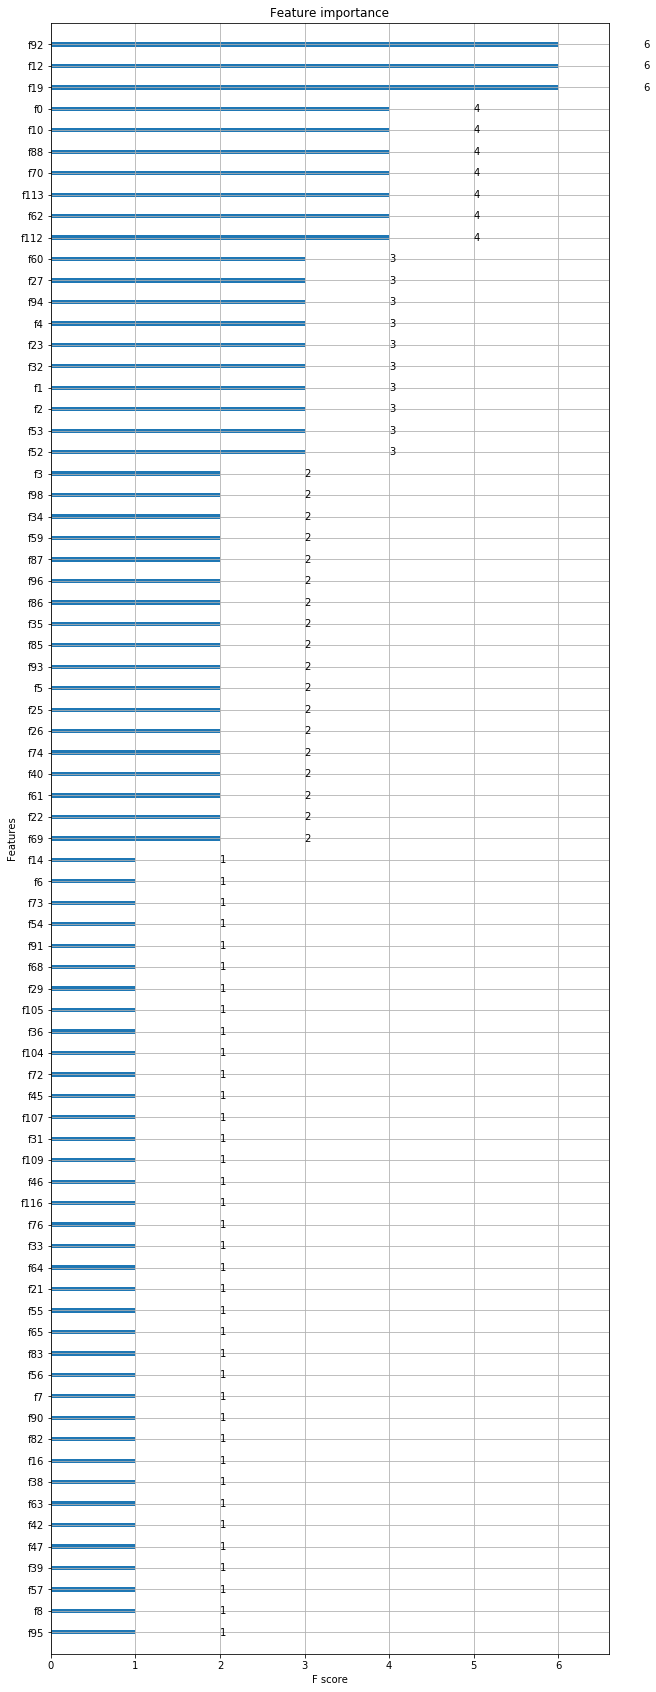

In [127]:
x=xgb.plot_importance(bst)
x.figure.set_size_inches(10, 30) 

In [138]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [129]:
from math import sqrt

In [143]:
def run_model_ts(X_train,X_test,y_train,y_test,cols,pred_window,bst):
    
    ll = []
    
    df_predictions = pd.DataFrame(ll)
    

    xgbpredict = xgb.DMatrix(X_test.values)

    y_pred = bst.predict(xgbpredict)


    df_predictions[cols] = y_pred

    mse_err = mean_squared_error(y_pred,y_test.values)

    mae_err = mean_absolute_error(y_pred,y_test.values)
    
    mae_err_std = sqrt((mae_err*(1-mae_err))/y_test.size)

    rmse = sqrt(mse_err)
    
    mse_err_std = sqrt((rmse*(1-rmse))/y_test.size)
    
    rmse_up = rmse+mse_err_std
    
    rmse_down = rmse-mse_err_std
    
    mae_up = mae_err+mae_err_std
    
    mae_down = abs(mae_err-mae_err_std)

    print('rmse: %.2f:[%.2f-%2f]'%(rmse,rmse_down,rmse_up) )

    print('mae_err: %.2f:[%.2f-%2f]'%(mae_err,mae_down,mae_up))

    mape = mean_absolute_percentage_error(y_pred,y_test.values)
    
    mape_err_std = sqrt((mape*(1-mape))/y_test.size)
    
    mape_up = mape+mape_err_std
    
    mape_down = mape-mape_err_std

    print('mape: %.2f:[%.2f-%2f]'%(mape,mape_down,mape_up))

    df_predictions.index = pred_window
    
    df_predictions['Date'] = df_predictions.index
    
    return df_predictions

In [144]:
df_pred = run_model_ts(X_train,X_test,y_train,y_test,'AveragePrice_mean',prediction_window,bst)

rmse: 0.09:[-0.03-0.209114]
mae_err: 0.08:[0.03-0.197667]
mape: 0.08:[-0.03-0.191741]


### I have chosen RMSE error as a standard measure for regression problems wich can be expressed in units of target variable and direction of the error and penalizes large errors. 
### MAE treates all error (differences) same.
### MAPE gives percentage how predictions are off of the actual. In this case is 8%.

### We can see that predictions lay even in the range of one standard deviation. As we have that predictions lay in longer interval for example two or three standard deviations that would indicate worse prediction.

In [132]:
def plot_all(df1,df2,df_pred,col):
    
    fig,ax=plt.subplots(figsize=(12,10))
    
    ax=sns.scatterplot('Date',col,data=df1,color='b')
    
    ax=sns.scatterplot('Date',col,data=df2,color='r')
    
    ax=sns.scatterplot('Date',col,data=df_pred,color='y')
    
    ax.set_xlim(df1['Date'].min()-pd.Timedelta(1,unit='W'),df2['Date'].max()+pd.Timedelta(1,unit='W'))

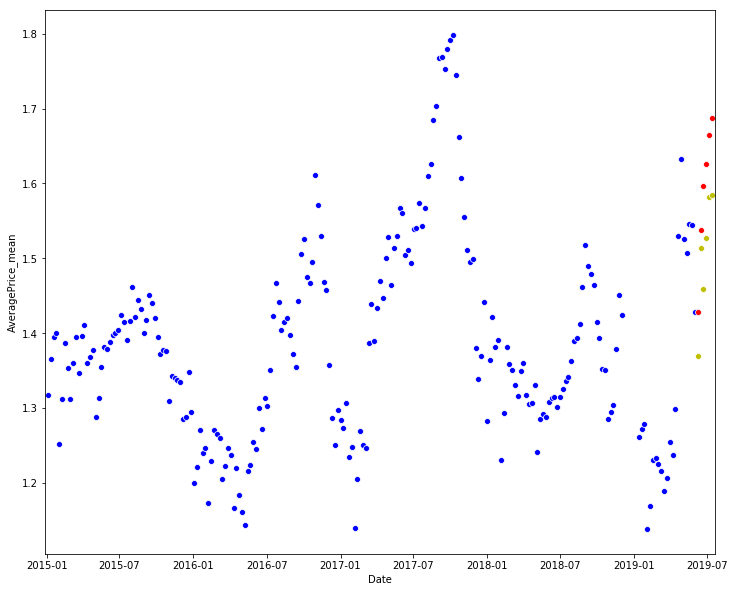

In [133]:
df_train = df_all_filt[(df_all_filt['Date']<prediction_window[0])]
df_test = df_all_filt[(df_all_filt['Date']>=prediction_window[0])&(df_all_filt['Date']<=prediction_window[-1])]
plot_all(df_train,df_test,df_pred,'AveragePrice_mean')

#### Look at the best and worst predictions

In [108]:
df_test_all = pd.merge(df_test[['Date','AveragePrice_mean']],df_pred,on='Date',how='inner')

In [109]:
df_test_all

,Date,AveragePrice_mean_x,AveragePrice_mean_y
0,2019-06-09,1.428148,1.321769
1,2019-06-16,1.538333,1.485816
2,2019-06-23,1.596481,1.487966
3,2019-06-30,1.626574,1.559322
4,2019-07-07,1.664762,1.590834
5,2019-07-14,1.686952,1.590834


In [111]:
df_test_all['diff'] = abs(df_test_all.AveragePrice_mean_x-df_test_all.AveragePrice_mean_y)

In [112]:
df_test_all

,Date,AveragePrice_mean_x,AveragePrice_mean_y,diff
0,2019-06-09,1.428148,1.321769,0.106379
1,2019-06-16,1.538333,1.485816,0.052518
2,2019-06-23,1.596481,1.487966,0.108515
3,2019-06-30,1.626574,1.559322,0.067252
4,2019-07-07,1.664762,1.590834,0.073928
5,2019-07-14,1.686952,1.590834,0.096119


#### We see that there is a gap between prices at the end of May and beginning of June and mid June nad beginning of July. Probably due to high season stores raised prices more than usual.
#### However, model decided to approximate more gradually rise of prices. 